In [1]:
import matplotlib.pyplot as plt
"""constants derived from TPU paper"""
memory_time = 3.05*(10**-11)
clock_time = 1.42857*(10**-9) #this describes a 700 MHz System, each cycle takes this amount of time

class NormalPE:
    def __init__(self, r, c):
        self.val = 0
        self.r = r
        self.c = c
        self.n = None
        self.w = None
        self.nval = None
        self.wval = None
        self.counter = 0
        self.finished = False
        self.target = 0

    def addWVal(self,a):
        self.wval = a

    def addNVal(self, a):
        self.nval = a

    def set_target(self, t):
        self.target = t

    def compute(self):
        self.val += self.nval*self.wval
        self.counter+=1
        self.globalchecker()

    def globalchecker(self):
        if(self.counter >= self.target):
            self.finished = True

    def getFinal(self):
        return self.val

    def addWNeighbor(self,p):
        self.w = p

    def addNeighbor(self,p):
        self.n = p

    def __str__(self):
        string = ''
        string +=  'PE(%s, %s) ' % (self.r,self.c)
        string += ' Val: %s ' %(self.val)
        string.ljust(35)
        newstring = ''
        newstring += 'Inputs: %s, %s' %(self.wval, self.nval) + '|'
        newstring.rjust(45)

        """
        if(self.n is None):
            string += 'No N '
        else:
            string += 'Nref(%s, %s)' % (self.n.r, self.n.c)

        if(self.w is None):
            string += 'No W '
        else:
            string += 'Wref(%s, %s)' % (self.w.r, self.w.c)"""
        return string+newstring

def initNormalSystolic(rows, rcols):
    sys = [ [NormalPE(i,j) for j in range (rcols)] for i in range(rows)]

    for i in range(len(sys)-1, -1, -1):
        for j in range(len(sys[0]) - 1, -1, -1):
            if(j-1 >= 0):
                sys[i][j].addWNeighbor(sys[i][j-1])
            if(i - 1 >= 0):
                sys[i][j].addNeighbor(sys[i-1][j])
    return sys

def printSystolic(sys):
    for i in range(len(sys)):
        for j in range(len(sys[0])):
            print(sys[i][j], end=' ')
        print()

def recursegetDiagonals(d):
    if(all(v is None for v in d[-1]) ):
        return d[0:-1]
    else:
        refs = []
        for i in d[-1]:
            if(i.e == None and i.s == None):
                refs.append(None)
            elif(i.e == None and i.s != None):
                refs.append(i.s)
            elif(i.e != None and i.s == None):
                refs.append(i.e)
            else:
                refs.append(i.e)
                refs.append(i.s)
        d.append(list(set(refs)) )
        return recursegetDiagonals(d)

import numpy as np

def recurseNormalApass(sys,A, sr, sc, it):
    colA = len(A[0]) -1
    output = []
    for i in range(0, sr):
        if(it < colA + sr and it - i >= 0 and it - i <= colA):
            sys[i][0].addWVal(A[i][it - i])

def recurseNormalBpass(sys,B, sr, sc, it):
    rowB = len(B) - 1
    for i in range(0, sc):
        if(it < rowB + sc and it - i >= 0 and it - i <= rowB):
            sys[0][i].addNVal(B[it - i][i])

def autoNormalPassinNextWaveofData(sys, A, B, i):
    sr = len(sys)
    sc = len(sys[0])
    recurseNormalApass(sys, A, sr,sc, i)
    recurseNormalBpass(sys, B, sr, sc, i)

def matCheckerNormal(Ar, Bc):
    if(Ar != Bc):
        raise Exception("Matrix Sizes A,B aren't compatible")

def sysCheckerNormal(Ar, Bc, sr, sc):
    if(Ar != sr or Bc != sc):
        raise Exception("Systolic array isn't sized properly for input matrices")

import time
def backrunSystolicNormal(sys,A, B, verbose = True):
        start = time.time()
        Ar = len(A)
        Ac = len(A[0])
        Br = len(B)
        Bc = len(B[0])
        matCheckerNormal(Ac, Br)
        sysCheckerNormal(Ar, Bc, len(sys), len(sys[0]))

        output = np.zeros((len(sys), len(sys[0])))
        for i in sys:
            for j in i:
                j.set_target(Ac)

        count = 0
        finish = False
        cutout = 0
        end = time.time()
        
        while(not finish):
            #passinNextWaveofData(sys, A, B, count)
            autoNormalPassinNextWaveofData(sys, A,B, count)
            if verbose:
                print('start')
                printNormalSystolic(sys)
            all_check = True
            cutoutstart = time.time()
            for j in range(len(sys)-1, -1, -1):
                for k in range( len(sys[0]) - 1, -1, -1 ):
                    i = sys[j][k]
                    if(i.nval is not None and i.wval is not None and not i.finished):
                        i.compute()
                        i.nval = None
                        i.wval = None
                    if(i.n is not None and i.n.nval is not None):
                        i.addNVal(i.n.nval)
                    if(i.w is not None and i.w.wval is not None):
                        i.addWVal(i.w.wval)
                    if(i.finished):
                        output[i.r][i.c] = i.val

                    all_check = not(not all_check or not i.finished)
                    #all_check = False if not i.finished else all_check
            cutoutend = time.time()
            cutout += cutoutend - cutoutstart
            if(verbose):
                print('end')
                printNormalSystolic(sys)
                print(all_check)
            finish = all_check
            count +=1
        if(verbose):
            print('Systolic Propogation Clock Ticks: %s' % (count))
        
        return count, output, cutout/count, end - start

def padArray(sr, sc, sub):
    result = np.zeros((sr, sc))
    result[:len(sub), :len(sub[0])] = sub
    return result

import math
def blockNormalSystolicMultiply(sys, A, B, verbose = True):
    sr = len(sys)
    sc = len(sys[0])

    Ar = len(A)
    Ac = len(A[0])

    Br = len(B)
    Bc = len(B[0])

    matCheckerNormal(Ac, Br)
    out = np.zeros((Ar,Bc))
    trackiterations = 0
    clocks = 0
    for_freq = 0
    #for matrix multiplication between layers, the multiplication is a matrix vs a vector
    #the reason that sr is repeated here, it is assumed that chunks of size (sr,sr) and (sr, sc)
    start_time = time.time()
    delete = 0
    for r in range(0, math.ceil(Ar/sr)):
        rstart = r*sr
        rend = rstart + sr
        if(rend > Ar):
            rend = Ar
        for c in range(0, math.ceil(Ac/sr)):
            cstart = c*sr
            cend = cstart + sr
            if(cend > Ac):
                cend = Ac
            #print(rstart, rend, cstart, cend)
            #mult = np.dot(padArray(sr, sr, A[rstart:rend, cstart:cend]), padArray(sr, sc, B[cstart:cend, 0].reshape(-1, 1)))
            clks, m,for_frequency, deleteTime = backrunSystolicNormal(sys, padArray(sr, sr, A[rstart:rend, cstart:cend]), padArray(sr, sc, B[cstart:cend, 0].reshape(-1, 1)), verbose = verbose )
            clocks = clks
            delete += deleteTime
            for_freq += for_frequency
            out[rstart:rend, 0:] = out[rstart:rend, 0:] + m[0:rend - rstart, :]
            sys = initNormalSystolic(sr, sc)
            trackiterations+=1
        #print('Finished section')
    total_time = time.time() - start_time
    if verbose:
        print('Total Number of Systolic Iterations: %s' %(trackiterations))
    return out, trackiterations, clocks, for_freq, total_time - delete



At systolic1 
At systolic2 
At systolic3 
At systolic4 
At systolic5 
At systolic6 
At systolic7 
At systolic8 
At systolic9 
At systolic10 
At systolic11 
At systolic12 
At systolic13 
At systolic14 
At systolic15 
At systolic16 
At systolic17 
At systolic18 
At systolic19 
At systolic20 
At systolic21 
At systolic22 
At systolic23 
At systolic24 
At systolic25 
At systolic26 
At systolic27 
At systolic28 
At systolic29 
At systolic30 
At systolic31 
At systolic32 
At systolic33 
At systolic34 
At systolic35 
At systolic36 
At systolic37 
At systolic38 
At systolic39 
At systolic40 
At systolic41 
At systolic42 
At systolic43 
At systolic44 
At systolic45 
At systolic46 
At systolic47 
At systolic48 
At systolic49 
At systolic50 
At systolic51 
At systolic52 
At systolic53 
At systolic54 
At systolic55 
At systolic56 
At systolic57 
At systolic58 
At systolic59 
At systolic60 
At systolic61 
At systolic62 
At systolic63 
At systolic64 
At systolic65 
At systolic66 
At systolic67 
At s

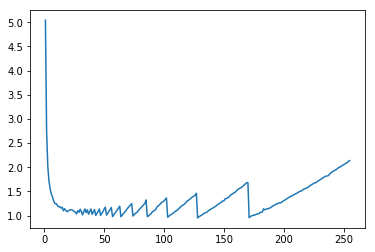

In [2]:
A = np.random.rand(512,512)
B = np.random.rand(512,1)

#sys = initNormalSystolic(256,1)
#res, its, clks, for_freq, t = blockNormalSystolicMultiply(sys, A, B, False)

shapes = np.arange(1, 256, 1)
times = []
iterations = []
clocks = []
for_freqs = []
for i in shapes:
    result, its, clks, for_freq, t = blockNormalSystolicMultiply(initNormalSystolic(i,1), A, B, False)
    times.append(t)
    iterations.append(its)
    clocks.append(clks)
    for_freqs.append(for_freq)
    print('At systolic%s '% (i))
    del result, its, clks, for_freq, t
    
plt.plot(shapes, times)
plt.show()



In [3]:
class CircularPE:
    def __init__(self, i):
        self.val = 0
        self.i = i
        self.e = None
        self.input = False
        self.val = 0
        self.nval = 0
        self.bval = None
        self.passon = None
        self.counter = 0
        self.finished = False
        self.target = 0

    def addENeighbor(self,x):
        self.e = x

    def addBVal(self, x):
        self.bval = x

    def addNVal(self,x):
        self.nval = x

    def computeVal(self):
        self.val += self.nval*self.bval
        self.counter+=1
        if(self.counter >= self.target):
            self.finished = True

    def set_target(self,x):
        self.target = x

    def addInputChannel(self):
        self.input = True

    def __str__(self):
        string = ''
        string += 'PE:%s, BV:%s, NV:%s, P:%s, V:%s||| ' % (self.i, self.bval, self.nval, self.passon, self.val)
        #string += 'P:%s,||| ' % (self.passon)
        return string

def initCircularSystolic(elements):
    sys = [CircularPE(i) for i in range(elements)]
    if(elements%2 != 0):
        raise Exception('Systolic Array Size Must be Divisible by Two for Circulation')
    for i in range(0, len(sys)):
        sys[i].addENeighbor(sys[i-1])
        if(i == len(sys)//2 or i == 0):
            sys[i].addInputChannel()
    return sys

def printCircularSystolic(sys):
    for i in range(len(sys)):
        print(sys[i], end='')
    print()

def recursegetDiagonals(d):
    if(all(v is None for v in d[-1]) ):
        return d[0:-1]
    else:
        refs = []
        for i in d[-1]:
            if(i.e == None and i.s == None):
                refs.append(None)
            elif(i.e == None and i.s != None):
                refs.append(i.s)
            elif(i.e != None and i.s == None):
                refs.append(i.e)
            else:
                refs.append(i.e)
                refs.append(i.s)
        d.append(list(set(refs)) )
        return recursegetDiagonals(d)

import numpy as np

def recurseCircularApass(sys, A, it):
    add = []
    midpoint = len(sys)//2
    for i in range(0, len(sys)):
        shifter = it - i%midpoint
        if(shifter >= 0 and shifter <= len(A) - 1):
            if(i < midpoint):
                sys[i].addNVal(A[i][shifter])
                #add.append(A[i][shifter])
            else:
                sys[i].addNVal(A[i][shifter - midpoint])
                #add.append(A[i][shifter - midpoint])
        else:
            sys[i].addNVal(0)
            #add.append(0)

def recurseCircularBPass(sys, B, it):
    midpoint = len(B)//2
    if(0 + it < midpoint or midpoint + it < len(B)):
        sys[0].addBVal(B[0+it][0])
        sys[len(sys)//2].addBVal(B[midpoint + it][0])

def primitive(sys, A, B):
    a = np.zeros((len(sys) + 1, len(sys)))


def autoCircularPassinNextWaveofData(sys, A, B, i):
    sr = len(sys)
    recurseApass(sys, A, sr,sc, i)
    recurseBpass(sys, B, sr, sc, i)

def matCheckerCircular(Ar, Ac, Br, Bc):
    if(Ac != Br):
        raise Exception("Matrix Sizes A,B aren't compatible")
    if(Ac%2 != 0 or Br%2 != 0):
        raise Exception("In order to use CircularSystolic, the matrices must be divisuble by Two")
    if(Ac != Ar):
        raise Exception("The matrix must be square for CircularSystolic to Work")

def sysCheckerCircular(Br, l):
    if(Br!= l):
        raise Exception("Systolic array isn't sized properly for input matrices")

import time
def backrunCircularSystolic(sys,A, B, verbose = True):
        start = time.time()
        Ar = len(A)
        Ac = len(A[0])
        Br = len(B)
        Bc = len(B[0])
        matCheckerCircular(Ar, Ac, Br, Bc)
        sysCheckerCircular(Br, len(sys))

        for i in sys:
            i.set_target(Ac)

        output = np.zeros((Ac , Bc))
        lbuffer = None
        stahp = False
        k = 0
        cutout = 0
        end = time.time()
        while(not stahp):
            recurseCircularApass(sys, A, k)
            recurseCircularBPass(sys, B, k)
            #print(input_result)
            #print(input_B_result)
            """for x in range(0, 2):
                if(input_B_result is not None):
                    sys[x*(len(sys)//2)].addBVal(input_B_result[x])"""

            """for j in range(0, len(sys)):
                if(input_result is not None):
                    sys[j].addNVal(input_result[j])"""

            stahp = True
            start_time = time.time()
            for y in range(len(sys) -1, -1, -1):
                i = sys[y]
                if(i.bval is None and i.e.passon is not None):
                    if(y != 0):
                        i.bval = i.e.passon
                    else:
                        i.bval = lbuffer

                if(i.bval is not None and i.nval is not None and not i.finished):
                    i.computeVal()
                    if(y != len(sys) - 1):
                        i.passon = i.bval
                        i.bval = None
                    else:
                        lbuffer = i.passon
                        i.passon = i.bval
                        i.bval = None
                if i.finished:
                    output[y][0] = i.val
                stahp = stahp and i.finished
            delta = time.time() - start_time
            cutout += delta
            if(verbose):
                printCircularSystolic(sys)
            k+=1
        return output, k, cutout/k, end - start

def padArray(sr, sc, sub):
    result = np.zeros((sr, sc))
    result[:len(sub), :len(sub[0])] = sub
    return result

def blockCircularChecker(Ac, Br):
    if(Ac != Br):
        assert Exception('Matrices arent compatible for multiplication')

import math
def blockCircularSystolicMultiply(sys, A, B, verbose = True):
    sr = len(sys)

    Ar = len(A)
    Ac = len(A[0])

    Br = len(B)
    Bc = len(B[0])

    blockCircularChecker(Ac, Br)

    out = np.zeros((Ar,Bc))
    trackiterations = 0
    clocks = 0
    for_freq = 0
    #for matrix multiplication between layers, the multiplication is a matrix vs a vector
    #the reason that sr is repeated here, it is assumed that chunks of size (sr,sr) and (sr, sc)
    delete = 0
    start_time = time.time()
    for r in range(0, math.ceil(Ar/sr)):
        rstart = r*sr
        rend = rstart + sr
        if(rend > Ar):
            rend = Ar
        for c in range(0, math.ceil(Ac/sr)):
            cstart = c*sr
            cend = cstart + sr
            if(cend > Ac):
                cend = Ac
            #print(rstart, rend, cstart, cend)
            #mult = np.dot(padArray(sr, sr, A[rstart:rend, cstart:cend]), padArray(sr, sc, B[cstart:cend, 0].reshape(-1, 1)))
            m, k, for_frequency, cutout = backrunCircularSystolic(sys, padArray(sr, sr, A[rstart:rend, cstart:cend]), padArray(sr, 1, B[cstart:cend, 0].reshape(-1, 1)), verbose = verbose )
            for_freq += for_frequency
            clocks = k
            delete+=cutout
            out[rstart:rend, 0:] = out[rstart:rend, 0:] + m[0:rend - rstart, :]
            sys = initCircularSystolic(sr)
            trackiterations+=1
        #print('Finished section')
    end_time = time.time() - start_time
    if verbose:
        print('Total Number of Systolic Iterations: %s' %(trackiterations))
    return out, trackiterations, clocks, for_freq, end_time - delete



In [4]:
times1 = []
iterations1 = []
clocks1 = []
freq1 = []

for i in shapes:
    if(i%2 ==0):
        result, its, clks, freq, t = blockCircularSystolicMultiply(initCircularSystolic(i), A, B, False)
        times1.append(t)
        iterations1.append(its)
        clocks1.append(clks)
        freq1.append(freq)
        print('At Circular systolic%s '% (i))
 

At Circular systolic2 
At Circular systolic4 
At Circular systolic6 
At Circular systolic8 
At Circular systolic10 
At Circular systolic12 
At Circular systolic14 
At Circular systolic16 
At Circular systolic18 
At Circular systolic20 
At Circular systolic22 
At Circular systolic24 
At Circular systolic26 
At Circular systolic28 
At Circular systolic30 
At Circular systolic32 
At Circular systolic34 
At Circular systolic36 
At Circular systolic38 
At Circular systolic40 
At Circular systolic42 
At Circular systolic44 
At Circular systolic46 
At Circular systolic48 
At Circular systolic50 
At Circular systolic52 
At Circular systolic54 
At Circular systolic56 
At Circular systolic58 
At Circular systolic60 
At Circular systolic62 
At Circular systolic64 
At Circular systolic66 
At Circular systolic68 
At Circular systolic70 
At Circular systolic72 
At Circular systolic74 
At Circular systolic76 
At Circular systolic78 
At Circular systolic80 
At Circular systolic82 
At Circular systolic

In [5]:
print(shapes[1::2])

[  2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36
  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72
  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106 108
 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144
 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178 180
 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214 216
 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250 252
 254]


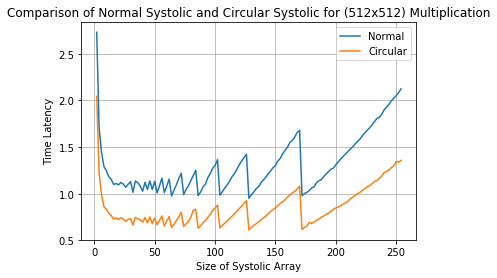

In [6]:
plt.plot(shapes[1::2], times[1::2], label = "Normal")
plt.plot(shapes[1::2], times1, label = "Circular")
plt.xlabel("Size of Systolic Array")
plt.ylabel("Time Latency")
plt.title("Comparison of Normal Systolic and Circular Systolic for (%sx%s) Multiplication" % (len(A), len(A)))
plt.grid()
plt.legend()
plt.savefig('comparisonfig')
plt.show()

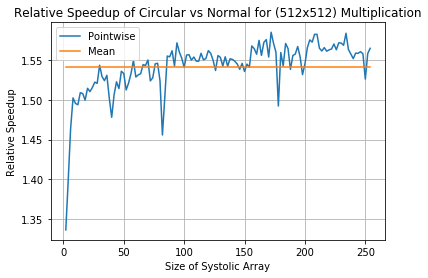

In [7]:
m = np.mean(np.array(times[1::2])/np.array(times1))

plt.plot(shapes[1::2], np.array(times[1::2])/np.array(times1), label = 'Pointwise')
plt.plot(shapes[1::2], [m for i in range(0, len(times1))], label = 'Mean')
plt.title('Relative Speedup of Circular vs Normal for (%sx%s) Multiplication' % (len(A), len(A)) )
plt.xlabel('Size of Systolic Array')
plt.ylabel('Relative Speedup')
plt.legend()
plt.grid()
plt.savefig('AverageSpeedup')
plt.show()

In [8]:
test_shapes = [16, 32, 64,128,256,512,1024, 2048, 4096]
import math
reps = lambda mat_size, r,c: math.ceil(r/mat_size)*math.ceil(c/mat_size)
memory = lambda mat_size, r,c: mat_size**2 + mat_size
clocks = lambda mat_size, r, c: 2*mat_size - 1

def find_optimum_shape(mat_mult):
    shapes = np.arange(1,256)
    lats = []
    for i in shapes:
        lats.append(reps(i, mat_mult, mat_mult)*(memory_time*memory(i, mat_mult, mat_mult) + clock_time*clocks(i, mat_mult, mat_mult) ))
    return shapes[np.argmin(lats)]

stuff = []
performance_metrics = []
clock_metrics = []
rep_metrics = []

for i in test_shapes:
    print(find_optimum_shape(i))
    optimum = find_optimum_shape(i)
    sysnormal = initNormalSystolic(find_optimum_shape(i),1)
    sysnormal_largest = initNormalSystolic(254,1)
    if(optimum%2 != 0):
        optimum +=1
    syscircular = initCircularSystolic(optimum )
    
    A = np.random.rand(i, i)
    B = np.random.rand(i, 1)

    result, its, clks, for_freq, t = blockNormalSystolicMultiply(sysnormal, A, B, False)
    result, its1, clks1, for_freq1, t1 = blockNormalSystolicMultiply(sysnormal_largest, A, B, False)
    result, its2, clks2, for_freq2, t2 = blockCircularSystolicMultiply(syscircular, A, B, False)
    
    lowest_for_freq = min(for_freq, for_freq1, for_freq2)
    
    performance_metrics.append([t, t1, t2])
    clock_metrics.append([clks, clks1, clks2])
    rep_metrics.append([its, its1, its2])


16
32
64
128
128
171
205
228
241


In [9]:
performance_metrics = np.array(performance_metrics)
clock_metrics = np.array(clock_metrics)
rep_metrics = np.array(rep_metrics)

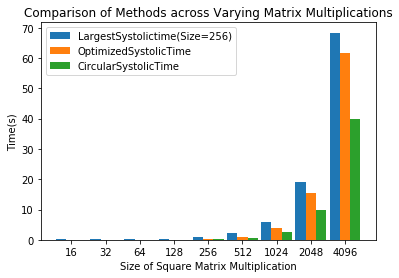

In [19]:
ind = np.arange(len(test_shapes))*10
width = 3
plt.bar(ind, performance_metrics[:,1], width, label= 'LargestSystolictime(Size=256)')
plt.bar(ind + width, performance_metrics[:,0], width, label='OptimizedSystolicTime')
plt.bar(ind + width*2, performance_metrics[:,2], width, label = 'CircularSystolicTime')
plt.ylabel('Time(s)')
plt.xlabel('Size of Square Matrix Multiplication')

plt.title('Comparison of Methods across Varying Matrix Multiplications')
plt.xticks(ind + width*3/3, test_shapes)
plt.legend(loc='best')
plt.savefig('ComparsionAcrossMultiplications', dpi = 1200)
plt.show()

3 220.181186183 -1.5
3 58.7149086623 6.5
3 15.6164428585 14.5
3 4.03261430738 22.5
3 3.95330676894 30.5
3 2.20460118378 38.5
3 1.53676323441 46.5
3 1.22654776642 54.5
3 1.10690557115 62.5
3 302.535522388 1.5
3 89.5713772024 9.5
3 24.3098306737 17.5
3 6.21923500395 25.5
3 6.12645402914 33.5
3 3.39805390705 41.5
3 2.38334986597 49.5
3 1.93935442152 57.5
3 1.71730581657 65.5


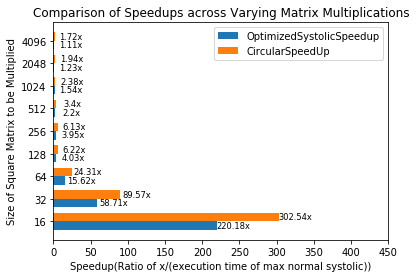

In [14]:
ind = np.arange(len(test_shapes))*8

fig, ax = plt.subplots()

width = 3
rect1 = ax.barh(ind, performance_metrics[:,1]/performance_metrics[:,0], width, label='OptimizedSystolicSpeedup')
rect2 = ax.barh(ind + width, performance_metrics[:,1]/performance_metrics[:,2], width, label='CircularSpeedUp')
ax.set_ylabel('Time(s)')
ax.set_title('Comparison of Speedups across Varying Matrix Multiplications')
ax.set_ylabel('Size of Square Matrix to be Multiplied')
ax.set_xlabel('Speedup(Ratio of x/(execution time of max normal systolic))')
def autolabel(rects, act_val):
    """
    Attach a text label above each bar displaying its height
    """
    for ix,rect in enumerate(rects):
        height = rect.get_height()
        width = rect.get_width()
        print(height, width, rect.get_y())
        act = act_val[ix]
        ax.text(width + 22, rect.get_y(), '%sx' % round(act,2), ha='center', va='bottom', size = 'smaller')

autolabel(rect1, performance_metrics[:,1]/performance_metrics[:,0])
autolabel(rect2, performance_metrics[:,1]/performance_metrics[:,2])
ax.set_yticks(ind + width/2)
ax.set_yticklabels(test_shapes)
ax.set_xlim(0, 450)
ax.legend(loc='best')
plt.savefig('SpeedupsComparsionAcrossMultiplications', dpi = 1200)
plt.show()

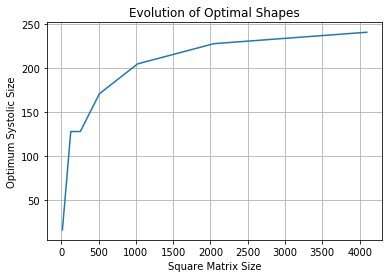

In [18]:
opts = []
for i in test_shapes:
    opts.append(find_optimum_shape(i))
    
plt.plot(test_shapes, opts)
plt.title('Evolution of Optimal Shapes')
plt.xlabel('Square Matrix Size')
plt.ylabel('Optimum Systolic Size')
plt.grid()
plt.savefig('Evolution', dpi = 1200)
plt.show()